In [1]:
%reload_ext autoreload
%autoreload 2
## sys package
import os, sys
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2"  # specify which GPU(s) to be used
sys.path.append("./prediction_models/input/prostate-cancer-grade-assessment/")
## warning off
import warnings
warnings.filterwarnings("ignore")

## general package
import random
from tqdm import tqdm_notebook as tqdm
import numpy as np
import pandas as pd
import torch
from torch.utils.data import *
from sklearn.metrics import cohen_kappa_score, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import pickle
# device = torch.device("cuda:4" if torch.cuda.is_available() else "cpu") 
# print(device)

## customized package
from input.inputPipeline_stiching import PandaPatchDataset, crossValDataloader, data_transform
from model.resnext_ssl_stiching import Model_Infer as Model

In [2]:
data_dir = './input/panda-36x256x256-tiles-data/train'
csv_file = './input/panda-36x256x256-tiles-data/4_fold_whole_train.csv'
# SAMPLE = './input/prostate-cancer-grade-assessment/sample_submission.csv'

In [3]:
models = []
weights = [f'./train/weights/Resnext50_medreso_36patch_adam_cosine_bin/Resnext50_medreso_36patch_adam_cosine_bin_{i}_best.pth.tar' for i in [0,1,2,3]]
for path in weights:
    pretrained_dict = torch.load(path)
    model = Model(n = 5)
    model_dict = model.state_dict()
    pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
    model_dict.update(pretrained_dict)
    model.load_state_dict(pretrained_dict)
    model.eval()
    model.cuda()
    models.append(model)

del pretrained_dict

In [4]:
sz = 256
bs = 1
folds = 4
tsfm = data_transform()
tsfm = None
dataset = PandaPatchDataset(csv_file, data_dir, sz, transform=tsfm, N = 36, rand = False)
crossValData = crossValDataloader(csv_file, dataset, bs)

In [5]:
names = [] ## record image names and predictions
preds, preds_r, preds_k = [], [], []
grades, grades_r, grades_k = [], [], []
probs, probs_r, probs_k = [], [], []
for fold in [0,3]:
    ## Model inference
    _, dataloader0 = crossValData(fold)
    model = models[fold]
    with torch.no_grad():
        for idx, data in enumerate(tqdm(dataloader0)):
            img, name, provider, grade = data['img'], data['name'], data['datacenter'], data['isup_grade']
            img = img.cuda()
            logits = model(img)['out']
            preds.append(logits.sigmoid().sum(1).round().cpu())
            probs.append(logits.sigmoid().cpu())
            names.append(name)
            grades.append(grade.sum(1).cpu())
            if provider[0] == "radboud":
                preds_r.append(logits.sigmoid().sum(1).round().cpu())
                grades_r.append(grade.sum(1).cpu())
                probs_r.append(logits.sigmoid())
            else:
                preds_k.append(logits.sigmoid().sum(1).round().cpu())
                grades_k.append(grade.sum(1).cpu())
                probs_k.append(logits.sigmoid())
#             if idx >= 50:
#                 break

In [6]:
probs_ = torch.cat(probs, 0).numpy()
grades_ = torch.cat(grades, 0).numpy().astype(int)
probs_r_ = torch.cat(probs_r, 0).cpu().numpy()
grades_r_ = torch.cat(grades_r, 0).cpu().numpy().astype(int)

In [7]:
probs_ = probs_r_
grades_ = grades_r_

best thrshold 0.8855946063995361, with index 110.
best thrshold 1.662549376487732, with index 126.
best thrshold 2.5941038131713867, with index 120.
best thrshold 3.3877930641174316, with index 189.
best thrshold 4.209769248962402, with index 130.


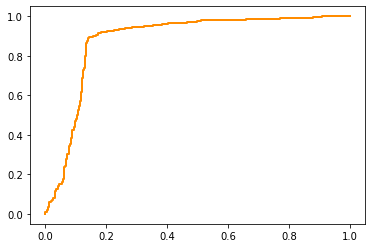

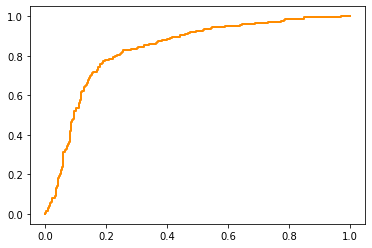

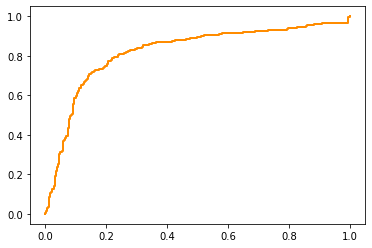

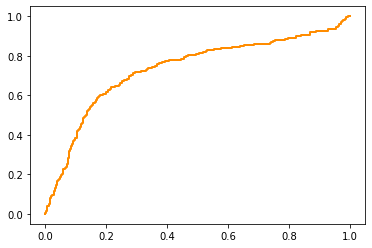

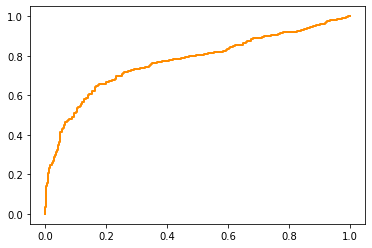

In [34]:
for i in [1,2,3,4,5]:
    idx_tmp_0 = np.where(grades_ == i - 1)
    idx_tmp_1 = np.where(grades_ == i)
    grades_tmp = list(grades_[idx_tmp_0]) + list(grades_[idx_tmp_1])
    grades_tmp = (np.asarray(grades_tmp) >= i).astype(int)
    probs_tmp = list(probs_[idx_tmp_0]) + list(probs_[idx_tmp_1])
    probs_tmp = np.array(probs_tmp)
    probs_tmp = probs_tmp.sum(1)
    # grades_tmp = (grades_ >= i).astype(int)
    fpr, tpr, thresholds = roc_curve(grades_tmp, probs_tmp)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange',
         lw=2)
    distance = (0 - fpr) ** 2 + (1 - tpr) ** 2
    indx = np.argmin(distance)
    th_optimal = thresholds[indx]
    print(f"best thrshold {th_optimal}, with index {indx}.")

In [24]:
def cal_kappa(th_opt):
    preds_wth_opt = []
    probs_aaa = []
    for i in range(len(probs_)):
        probs_tmp = probs_[i].sum()
        for j in range(6):
            if probs_tmp > th_opt[j] and probs_tmp <= th_opt[j + 1]:
                preds_wth_opt.append(j)

    kappa = cohen_kappa_score(grades_, preds_wth_opt, weights='quadratic')  
    return kappa

In [25]:
th_opt = np.asarray([-0.1, 0.37, 1.24, 2.24, 3.39, 4.21, 5.1])
best_th = 0
best_kappa = 0
for i in [1,2,3,4,5]:
    sweept = np.linspace(th_opt[i-1], th_opt[i+1], num=100)
    for k in range(len(sweept)):
        th_opt_tmp = []
        for j in range(len(th_opt)):
            if j != i:
                th_opt_tmp.append(th_opt[j])
            else:
                th_opt_tmp.append(sweept[k])
        kappa = cal_kappa(th_opt_tmp)
        if kappa >= best_kappa:
            best_kappa = kappa
            best_th = th_opt_tmp
            th_opt[i] = sweept[k]

In [26]:
best_kappa, th_opt

(0.9043199077067408,
 array([-0.1     ,  0.373737,  1.467103,  2.24    ,  3.03596 ,  4.391138,  5.1     ]))

In [31]:
th_opt = [0., 0.8855946063995361, 1.662549376487732, 2.5941038131713867, 3.3877930641174316, 4.209769248962402, 5.]
kappa = cal_kappa(th_opt)
print(kappa)

0.8977416147718518


In [9]:
names = np.concatenate(names)
grades = torch.cat(grades, 0).numpy().astype(int)
predictions = torch.cat(preds, 0).numpy().astype(int)
grades_r = torch.cat(grades_r, 0).numpy().astype(int)
predictions_r = torch.cat(preds_r, 0).numpy().astype(int)
grades_k = torch.cat(grades_k, 0).numpy().astype(int)
predictions_k = torch.cat(preds_k, 0).numpy().astype(int)

In [10]:
kappa = cohen_kappa_score(grades, predictions, weights='quadratic')
kappa_r = cohen_kappa_score(grades_r, predictions_r, weights='quadratic')
kappa_k = cohen_kappa_score(grades_k, predictions_k, weights='quadratic')
cm = confusion_matrix(grades, predictions)
ncm = cm / cm.astype(np.float).sum(axis=1)
print("The average kappa score is {}, radboud is {}, karolinska is {}.".format(kappa, kappa_r, kappa_k))

The average kappa score is 0.8888678919458545, radboud is 0.857867070600963, karolinska is 0.8959679383436251.


### Record a confusion dict with file name

In [14]:
# val_preds_p, val_label_p = predictions, grades

In [30]:
val_preds_p, val_label_p = torch.cat(preds_k,0).cpu().numpy(), grades_k

In [31]:
cfm_name = {}
for i in range(6):
    for j in range(6):
        if i == j:
            continue
        cfm_name["{}_{}".format(i, j)] = [] ## label i, preds, j
for idx in range(len(val_preds_p)):
    label = val_label_p[idx]
    preds = val_preds_p[idx]
    if label != preds:
        cfm_name["{}_{}".format(int(label), int(preds))].append(names[idx])

In [ ]:
f = open("Resnext50_medreso_36patch_adam_cosine_bin_0_cfm_name.pkl","wb")
pickle.dump(cfm_name,f)
f.close()

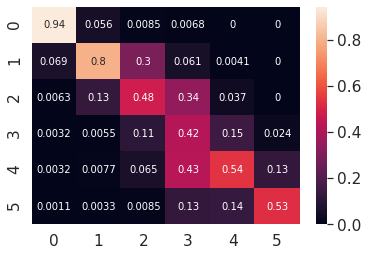

In [32]:
cm = confusion_matrix(val_label_p, val_preds_p)
ncm = cm / cm.astype(np.float).sum(axis=1)
df_cm = pd.DataFrame(ncm, range(6), range(6))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 10}) # font size
plt.show()